In [58]:
import openslide
import h5py
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import torch
from tqdm import tqdm
import json
from modules.swin import Swin
from modules.attmil import DAttention
from modules.contrastive1 import CLR
from PIL.Image import Image
import cv2
import random
import seaborn as sns
import os

In [2]:
# 外扩至margin_percentage
def get_area(pos_anchors,margin_percentage = 2,center_anchors=None,width_height=None):
        # 正样本尺寸的倍率
    if center_anchors is not None:
        margin = 10 * 512 * margin_percentage / 2
        center_anchor = (center_anchors[1],center_anchors[0])
    else:
        top, down, left, right = min(pos_anchors[:, 1]), max(pos_anchors[:, 1]), min(pos_anchors[:, 0]), max(pos_anchors[:, 0])
        center_anchor = ((top + down) // 2, (left + right) // 2)
        margin = max((down - top), (right - left)) * margin_percentage / 2

    top, down, left, right = np.array(
        [center_anchor[0]-margin, center_anchor[0]+margin, center_anchor[1]-margin, center_anchor[1]+margin],
        dtype=int
    )
    ori_coord = np.array([down,top,right,left])
    top,down,left,right = np.clip(top,0,width_height[1]),np.clip(down,0,width_height[1]),np.clip(left,0,width_height[0]),np.clip(right,0,width_height[0])
    # 补偿
    _gap = np.array([down,top,right,left]) 
    _coord = np.array([top,down,left,right]) 
    top,down,left,right = _coord + (_gap - ori_coord)

    return top,down,left,right,(down-top) * (right-left)
    
def screen_coords(scores, coords, top_left, bot_right,cam=None):
    bot_right = np.array(bot_right)
    top_left = np.array(top_left)
    mask = np.logical_and(np.all(coords >= top_left, axis=1), np.all(coords <= bot_right, axis=1))
    if cam is not None:
        return scores[mask], coords[mask], cam[mask]
    else:
        return scores[mask], coords[mask]

def random_area(width,height,min_area,max_area):
    # 随机生成符合要求的区域坐标
    while True:
        # 随机生成左上角坐标
        left = random.randint(0, width - 1)
        top = random.randint(0, height - 1)
        # 随机生成右下角坐标
        right = random.randint(left + 1, width)
        down = random.randint(top + 1, height)
        # 计算面积
        area = (right - left) * (down - top)
        # 如果面积符合要求，返回区域坐标
        if min_area <= area <= max_area:
            return (top, left, down, right)

In [34]:
# mask 模型
mask = CLR(da_act='relu',baseline='attn').eval()
mask.requires_grad_(False)
mask_cpt = 
mask.load_state_dict(mask_cpt['model'])

<All keys matched successfully>

In [78]:
# mask 模型
tea = CLR(da_act='relu',baseline='attn',mask_ratio_h=0.01,mask_ratio=0.5,mask_ratio_hr=0.5).eval()
tea.requires_grad_(False)
# normal
tea_cpt = torch.load('/home/xxx/data/mil/vis/model/da_101_mr50h1-0r50_is/fold_1_model_best_auc.pt',map_location='cpu')
# tumor
# mask_cpt = torch.load('/home/xxx/data/mil/vis/model/da_101_mr50h1-0r50_is/fold_0_model_best_auc.pt',map_location='cpu')
tea.load_state_dict(mask_cpt['teacher'])

<All keys matched successfully>

In [35]:
# 正常AB-MIL
pure = CLR(da_act='relu',baseline='attn').eval()
pure.requires_grad_(False)
# /nas/xxx/vis/pure_seed2023_fold_2_model_best_auc_for_tumor.pt 这个模型是我选出来做tumor slide，这个的recall要差一点，学姐可以去wandb上选，但最好先用这个，如果用这个模型做的效果不好再换。pure和mask是成套的，要换得一起换，要保证seed和fold一致
# normal
pure_cpt = torch.load('/home/xxx/data/mil/vis/model/da_pure/fold_1_model_best_auc.pt',map_location='cpu')
# tumor
# pure_cpt = torch.load('/home/xxx/data/mil/vis/model/da_pure/fold_0_model_best_auc.pt',map_location='cpu')

pure.load_state_dict(pure_cpt)

<All keys matched successfully>

下面两个是另外一篇文章

In [90]:
attn = DAttention(n_classes=2,dropout=0.25,act='relu',test=False).eval()
attn.requires_grad_(False)
cpt = torch.load('/home/xxx/data/mil/vis/attn_seed2021_fold_1_model_best_auc.pt',map_location='cpu')
attn.load_state_dict(cpt['model'])

<All keys matched successfully>

In [3]:
swin = Swin(pos='none',attn='swin',n_layers=1,da_act='tanh',ic=True,trans_conv=True).eval()
swin.requires_grad_(False)
cpt = torch.load('/home/xxx/data/mil/vis/swin_seed2021_fold_1_model_best_auc.pt',map_location='cpu')
swin.load_state_dict(cpt['model'])

<All keys matched successfully>

In [36]:
f_id = 'tumor_014'
# 打开WSI图像文件
tif_path = "/home/xxx/data/mil/c16/slide/"+f_id+".tif"
json_path = "/home/xxx/data/mil/c16/json/"+f_id+".json"
h5_path = "/home/xxx/data/mil/c16_clam_bio_seg/h5/"+f_id+".h5"
# tif_path = "/nas/xxx/data/camelyon16/slide/"+f_id+".tif"
# json_path = "/nas/xxx/data/camelyon16/json/"+f_id+".json"
# h5_path = "/nas/xxx/c16_bio_seg/data/feats/h5_files/"+f_id+".h5"
slide = openslide.OpenSlide(tif_path)
# 获取WSI图像的基本信息
width, height = slide.dimensions
# load anno
try:
    with open(json_path, 'r') as f:
        json_data = json.load(f)
except:
    json_data = None
    print('Normal slide')
# 读取现存features
patch = h5py.File(h5_path,"r")
features = torch.Tensor(patch['features'])
coords = np.array(patch['coords'])

In [69]:
# 这个用来查看指定slide在mask模型下的分类情况
def predict(f_id):
    # h5_path = "/home/xxx/data/mil/c16_clam_bio_seg/h5/"+f_id+".h5"
    h5_path = "/nas/xxx/c16_bio_seg/data/feats/h5_files/"+f_id+".h5"
    patch = h5py.File(h5_path,"r")
    features = torch.Tensor(patch['features'])
    coords = np.array(patch['coords'])
    pred,A = mask.forward_test(features, True,True)
    A = A.squeeze()
    pred = torch.nn.functional.softmax(pred)
    # pred[0][c]  # c=0是normal，c=1是tumor
    return pred[0][0]
predict('test_081')

/tmp/ipykernel_8433/2625244135.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.nn.functional.softmax(pred)


tensor(0.6070)

In [34]:
# 这个用于查看哪些slide再AB-MIL下表现比较差，
_thr = 0.8
cate = 1  # 0 normal ,1 tumor
def predict(f_id):
    h5_path = "/home/xxx/data/mil/c16_clam_bio_seg/h5/"+f_id+".h5"
    patch = h5py.File(h5_path,"r")
    features = torch.Tensor(patch['features'])
    coords = np.array(patch['coords'])
    pred,A = pure.forward_test(features, True,True)
    A = A.squeeze()
    pred = torch.nn.functional.softmax(pred)
    return pred[0][cate]
label = np.loadtxt("/home/xxx/data/mil/c16_clam_bio_seg/label.csv",delimiter=",", dtype=str)

for _l in label:
    if int(_l[1]) == cate:
        score = predict(_l[0])
        if score < _thr:
            print(_l[0],score)
# seed2021,fold1,attn模型判断错的tumor slide
# tumor_060 tensor(0.1422)  # swin 0.9
# tumor_070 tensor(0.0255)  # 0.68
# tumor_041 tensor(0.7110)  # 
# tumor_030 tensor(0.6352)
# tumor_012 tensor(0.7271)
# tumor_067 tensor(0.0125)  # 0.11
# tumor_098 tensor(0.0191)  # 0.21
# tumor_100 tensor(0.1706)  # 0.91
# tumor_002 tensor(0.1226)  # 0.36
# tumor_093 tensor(0.6514)
# tumor_080 tensor(0.1105)  # 0.87
# tumor_017 tensor(0.2754)
# tumor_027 tensor(0.0660)  # 0.67
# test_030 tensor(0.5051)
# test_040 tensor(0.6660)
# test_051 tensor(0.7411)
# test_052 tensor(0.6697)
# test_094 tensor(0.0362)   # 0.99   0号区域对比大
# test_097 tensor(0.7375)
# test_099 tensor(0.5972)
# test_110 tensor(0.7253)

/tmp/ipykernel_31501/3672499782.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.nn.functional.softmax(pred)


tumor_070 tensor(0.0328)
tumor_030 tensor(0.7342)
tumor_067 tensor(0.0093)
tumor_098 tensor(0.0600)
tumor_002 tensor(0.0923)
tumor_017 tensor(0.6753)
tumor_027 tensor(0.1969)
test_110 tensor(0.7621)


KeyboardInterrupt: 

In [11]:
def get_cam_1d(classifier, feat,attention):
    attention = torch.nn.functional.softmax(attention)
    features = torch.einsum('ns,n->ns', feat, attention)  ### n x fs
    tweight = list(classifier.parameters())[-2]
    cam_maps = torch.einsum('gf,cf->cg', features, tweight)
    return cam_maps

In [116]:
features.size(0)

9176

tensor([[0.0012, 0.9988]])


/tmp/ipykernel_26934/501866292.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(torch.nn.functional.softmax(pred_tea))
/tmp/ipykernel_26934/501866292.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  len_keep,mask_ = tea.get_mask(features.size(0),0,torch.nn.functional.softmax(A_tea))


<AxesSubplot:>

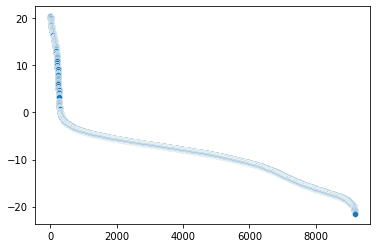

In [122]:
# tea
pred_tea,A_tea = tea.forward_test(features, True, True)
print(torch.nn.functional.softmax(pred_tea))
len_keep,mask_ = tea.get_mask(features.size(0),0,torch.nn.functional.softmax(A_tea))
A_mask = A_tea.clone()
A_tea = A_tea.squeeze()
A_mask[:] = 0
_m = A_mask.clone()
_m = _m.scatter_(1,mask_[:,:len_keep],1) == 1
A_mask[_m] = 1
A_mask = A_mask.squeeze()

_a,_ = torch.sort(A_tea,descending=True)
_a_vis = (_a - _a.min()) / (_a.max() - _a.min())
sns.scatterplot(x=np.array(list(range(_a.size(0)))),y=_a)

In [123]:
A_mask.sum()

tensor(4544.)

tensor([[0.0012, 0.9988]])
tensor(0.6364)


/tmp/ipykernel_26934/920204557.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(torch.nn.functional.softmax(pred_m))
/tmp/ipykernel_26934/3736863783.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention = torch.nn.functional.softmax(attention)
/tmp/ipykernel_26934/920204557.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  A_m = torch.nn.functional.softmax(A_m)


<AxesSubplot:>

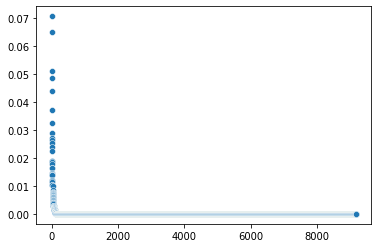

In [162]:
# mask predition
pred_m,A_m = mask.forward_test(features, True,True)
A_m = A_m.squeeze()
print(torch.nn.functional.softmax(pred_m))
# cam
cam_m = get_cam_1d(mask.predictor,mask.dp(mask.patch_to_emb(features.squeeze(0))),A_m)
cam_m = torch.nn.functional.softmax(cam_m,dim=0)
cam_m = cam_m[1]
cam_thr = cam_m.max()
print(cam_thr)
# softmax
A_m = torch.nn.functional.softmax(A_m)
_a,_ = torch.sort(A_m,descending=True)
_a_vis = (_a - _a.min()) / (_a.max() - _a.min())
sns.scatterplot(x=np.array(list(range(_a.size(0)))),y=_a)

tensor([[9.7710e-06, 9.9999e-01]])
tensor(0.6364)
tensor([0.9950, 0.8059, 0.7382])


/tmp/ipykernel_26934/1617909186.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(torch.nn.functional.softmax(pred_b))
/tmp/ipykernel_26934/3736863783.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention = torch.nn.functional.softmax(attention)
/tmp/ipykernel_26934/1617909186.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  A_b = torch.nn.functional.softmax(A_b)


<AxesSubplot:>

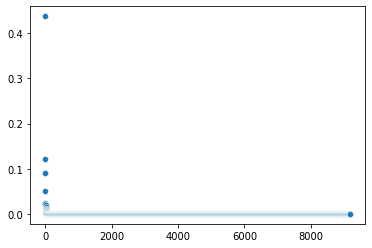

In [164]:
# ab-mil
pred_b,A_b = pure.forward_test(features, True,True)
A_b = A_b.squeeze()
print(torch.nn.functional.softmax(pred_b))
# cam 
cam_b = get_cam_1d(pure.predictor,pure.dp(pure.patch_to_emb(features.squeeze(0))),A_b)
cam_b = torch.nn.functional.softmax(cam_b,dim=0)
cam_b = cam_b[1]
print(cam_m.max())

# softmax
A_b = torch.nn.functional.softmax(A_b)
#A_norm = (A - A.min()) / (A.max() - A.min())
_a,_a_idx = torch.sort(A_b,descending=True)
_cam,_cam_idx = torch.sort(cam_b,descending=True)
print(_cam[:3])
sns.scatterplot(x=np.array(list(range(_a.size(0)))),y=_a)

In [78]:
# compute A
pred,A = attn(features, True,True)
A = A.squeeze()
print(torch.nn.functional.softmax(pred))
# cam
# cam = get_cam_1d(attn.classifier[0],attn.feature(features.squeeze(0)),A)
# # A = torch.nn.functional.softmax(cam[0])
# A = cam[1]

# softmax
A = torch.nn.functional.softmax(A)
A_norm = (A - A.min()) / (A.max() - A.min())
_a,_ = torch.sort(A_norm,descending=True)
sns.scatterplot(x=np.array(list(range(_a.size(0)))),y=_a)

NameError: name 'attn' is not defined

In [21]:
# compute A
pred,A = swin(features, True,True)
A = A.squeeze()
print(torch.nn.functional.softmax(pred))
# softmax
#A = torch.nn.functional.softmax(A)
# cam
cam = get_cam_1d(swin.predictor,swin.online_encoder(swin.dp(swin.patch_to_emb(features.squeeze(0))),no_pool=True),A)
cam = torch.nn.functional.softmax(cam,dim=0)
cam = cam[1]
_a,_ = torch.sort(A,descending=True)
_cam,_cam_idx = torch.sort(cam,descending=True)

#sns.scatterplot(x=np.array(list(range(_a.size(0)))),y=_a)
sns.scatterplot(x=np.array(list(range(_cam.size(0)))),y=_cam)

NameError: name 'swin' is not defined

## find the roi

In [92]:
# 查找符合大小的区域
patch_num = 1
patch_size = 512
if json_data is not None:
    for _pos in range(len(json_data['positive'])):
        _,_,_,_,area = get_area(np.array(json_data['positive'][_pos]['vertices']),width_height=[width,height])
        if area >= (patch_size*patch_num)**2:
            print(_pos,area**0.5 / patch_size)

0 21.75
1 1.02734375
2 9.1484375
3 41.94140625
6 2.40234375


In [165]:
# 定义裁剪参数
crop_size = 512  # 图块大小
stride = 512  # 步长
vis_level = 3           # 可视化slide 的level，这个决定了坐标的计算level，最好0，其它level坐标有偏移
vis_size = None # 448   #最后可视化图的大小
roi = 3 # -1->global, i->roi_index, roi_index 对应上一个代码块的输出，对tumor slide有用
alpha = .3  # 0-no_img,1-all_img
margin_percentage = 1.5#太大了内存吃不消，会卡死，这个主要看你roi的区域大小，roi太小这个就要大点，roi大了这个没必要弄得很大
#roi_coord = (94500,157000,0,width)  # 
roi_coord = None  # 指定一个roi区域，一般不用 指定(top,down,left,right)，覆盖roi参数, None就按照roi参数执行
rel_norm = False  #是否在roi区域范围内进行min-max正则化
filter_thr = 0.4   # attention的阈值，一般0.5比较好
filter_thr_cam = 0.5001 # cam_thr #cam的阈值，默认是mask模型cam的最大值，就可以屏蔽mask模型的病害图块，但要看这个值是不是太离谱，如果靠近0.5就可以，也要看ab-mil出来的效果，如果ab-mil病害太少，可以调小点
is_norm = True    #默认为True，是否对attention进行max-min正则
save_figure = False
vis_model = 'mask'  # attn or mask ，切换不同模型
_c_cam = np.array([0,255,255])  # 这里可以改cam的颜色，rgb
_c_attn = np.array([255,255,255]) # attn 颜色, 默认白色

## Attention + CAM

>>>>>>>>>>>> region coord gotten >>>>>>>>>>>
>>>>>>>>>>>> slide region gotten >>>>>>>>>>>
>>>>>>>>>>cam_roi>>>>>>>>>>>>
tensor([0.5680, 0.5953, 0.6033, 0.6075, 0.6350])
>>>>>>>>>>>> relative coords computed >>>>>>>>>>>
>>>>>>>>>>>> heatmap computed >>>>>>>>>>>
>>>>>>>>>>>> heatmap draw done>>>>>>>>>>>


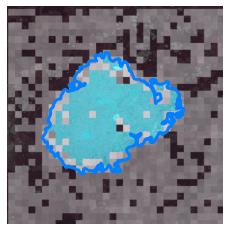

In [161]:
# plt.figure(figsize=(6,6),dpi=300)

if vis_model == 'attn':
    _A = A_b
    __cam = cam_b
    f_name = 'ABMIL_'
elif vis_model == 'mask':
    _A = A_m
    __cam = cam_m
    f_name = 'MASK_'

if roi_coord is None:
    if roi >= 0:
        if json_data is not None:
            pos_anchors = np.array(json_data['positive'][roi]['vertices'])
            top,down,left,right,_ = get_area(pos_anchors,margin_percentage,width_height=[width,height])
        else:
            # normal slide 我找的区域是ab-mil attention最高的那个图块的4周，_a_idx[0]就是这个。可以更换其他点，比如换一下0，或者换成cam排序最高的，_cam_idx
            top,down,left,right,_ = get_area(None,margin_percentage,coords[_a_idx[0]],width_height=[width,height])
    else:
        top,down,left,right = 0,height,0,width
    crop_coords = []
    # print(top,down,left,right)
    for i in range(top, down, stride):
        for j in range(left, right, stride):
            if j + crop_size > width or i + crop_size > height:
                continue
            crop_coords.append((j, i))
    right, down = np.max(crop_coords, 0) + crop_size
else:
    top,down,left,right = roi_coord
print(">>>>>>>>>>>> region coord gotten >>>>>>>>>>>")

scale_level_ratio = np.array(slide.level_dimensions[vis_level]) / np.array(slide.level_dimensions[0])
_w,_h = np.array((right-left, down-top))*scale_level_ratio
# _w,_h = (right-left, down-top)
region = slide.read_region((left, top), list(range(slide.level_count))[vis_level], (int(_w),int(_h))).convert('RGB')
print(">>>>>>>>>>>> slide region gotten >>>>>>>>>>>")
#
A_roi,coords_roi,cam_roi = screen_coords(_A,coords,(left,top),(right,down),cam=__cam)
print(">>>>>>>>>>cam_roi>>>>>>>>>>>>")
sorted_indices = np.argsort(cam_roi)
print(cam_roi[sorted_indices[-5:]])
#
img = np.array(region)
# 
coords_roi_rel = []
for i in range(len(coords_roi)):
    rel_x = coords_roi[i][0]-left
    rel_y = coords_roi[i][1] - top
    rel_x,rel_y = np.clip(rel_x,0,right-left),np.clip(rel_y,0,down-top)
    coords_roi_rel.append([rel_x,rel_y])
print(">>>>>>>>>>>> relative coords computed >>>>>>>>>>>")
# 
# 正则化
# roi区域内正则化
if is_norm:
    if rel_norm:
        A_roi = (A_roi - A_roi.min()) / (A_roi.max() - A_roi.min())
    #全局正则化
    else:
        A_roi = (A_roi - _A.min()) / (_A.max() - _A.min())
    # 筛选
A_roi[A_roi<filter_thr] = 0
cam_roi[cam_roi <= filter_thr_cam] = 0

heatmap_attn = np.zeros(img.shape)
heatmap_cam = np.zeros(img.shape)
alpha_mat_attn = np.ones(img.shape) * 0.5 * alpha
alpha_mat_cam = np.ones(img.shape) * 0.5 * alpha
# attention、cam染色
for _idx,_coord in enumerate(coords_roi_rel):
    A_flag = False
    cam_flag = False
    # # 这里可以改cam的颜色，rgb
    # _c = np.array([0,255,255])
    # # attn 颜色, 默认白色
    # _c_attn = np.array([255,255,255])

    # attention 颜色更改
    if A_roi[_idx] != 0:
        # attn 透明度更改
        # alpha_mat_attn[int(_coord[1]*scale_level_ratio[1]):int((_coord[1]+patch_size)*scale_level_ratio[1]),int(_coord[0]*scale_level_ratio[0]):int((_coord[0]+patch_size)*scale_level_ratio[0]),:] = A_roi[_idx]
        # attn 蒙版上色
        heatmap_attn[int(_coord[1]*scale_level_ratio[1]):int((_coord[1]+patch_size)*scale_level_ratio[1]),int(_coord[0]*scale_level_ratio[0]):int((_coord[0]+patch_size)*scale_level_ratio[0]),:] = A_roi[_idx] * _c_attn
        A_flag = True
    # cam 透明度更改
    if cam_roi[_idx] != 0:
        # 如果有cam则不管attention
        alpha_mat_attn[int(_coord[1]*scale_level_ratio[1]):int((_coord[1]+patch_size)*scale_level_ratio[1]),int(_coord[0]*scale_level_ratio[0]):int((_coord[0]+patch_size)*scale_level_ratio[0]),:] = 0
        heatmap_attn[int(_coord[1]*scale_level_ratio[1]):int((_coord[1]+patch_size)*scale_level_ratio[1]),int(_coord[0]*scale_level_ratio[0]):int((_coord[0]+patch_size)*scale_level_ratio[0]),:] = 0
        alpha_mat_cam[int(_coord[1]*scale_level_ratio[1]):int((_coord[1]+patch_size)*scale_level_ratio[1]),int(_coord[0]*scale_level_ratio[0]):int((_coord[0]+patch_size)*scale_level_ratio[0]),:] = 1-cam_roi[_idx]
        # cam 蒙版上色
        heatmap_cam[int(_coord[1]*scale_level_ratio[1]):int((_coord[1]+patch_size)*scale_level_ratio[1]),int(_coord[0]*scale_level_ratio[0]):int((_coord[0]+patch_size)*scale_level_ratio[0]),:] = _c_cam

        cam_flag = True
    else:
        alpha_mat_cam[int(_coord[1]*scale_level_ratio[1]):int((_coord[1]+patch_size)*scale_level_ratio[1]),int(_coord[0]*scale_level_ratio[0]):int((_coord[0]+patch_size)*scale_level_ratio[0]),:] = 0

    if not A_flag and not cam_flag:
        # 恢复非分割区域alpha除2
        alpha_mat_attn[int(_coord[1]*scale_level_ratio[1]):int((_coord[1]+patch_size)*scale_level_ratio[1]),int(_coord[0]*scale_level_ratio[0]):int((_coord[0]+patch_size)*scale_level_ratio[0]),:] = alpha
print(">>>>>>>>>>>> heatmap computed >>>>>>>>>>>")
#
# blended_image = (alpha_mat * img + (1-alpha_mat) * heatmap)
blended_image = (alpha_mat_attn * img + alpha_mat_cam*img + (1-alpha_mat_attn) * heatmap_attn + (1-alpha_mat_cam) * heatmap_cam)
blended_image = blended_image.astype(np.uint8)

if vis_size is not None:
    plt.imshow(cv2.resize(blended_image,dsize=(vis_size,vis_size)))
    scale_ratio = (vis_size / img.shape[0])*scale_level_ratio
else:
    plt.imshow(blended_image)
    scale_ratio = scale_level_ratio
print(">>>>>>>>>>>> heatmap draw done>>>>>>>>>>>")
plt.xlim(0,(right-left)*scale_ratio[0])
plt.ylim((down-top)*scale_ratio[1],0)
plt.axis("off")

if json_data is not None:
    for anchors in (json_data['positive']):
        _pos_anchors = np.array(anchors['vertices'])
        plt.plot((_pos_anchors[:, 0]-left) * scale_ratio[0] , (_pos_anchors[:,1]-top)* scale_ratio[1], color=(0,128/255,1),linewidth=3.0)

# if save_figure:
path = os.path.join("./vis_figure/sup/tumor/",f_id+f_name+str(roi)+'.png')
plt.savefig(path,dpi=450,bbox_inches='tight')

## Attention

In [175]:
vis_model = 'mask'  # attn or mask ，切换不同模型
is_norm = True
alpha=0.3

>>>>>>>>>>>> region coord gotten >>>>>>>>>>>
>>>>>>>>>>>> slide region gotten >>>>>>>>>>>
>>>>>>>>>>>> relative coords computed >>>>>>>>>>>
>>>>>>>>>>>> heatmap computed >>>>>>>>>>>
>>>>>>>>>>>> heatmap draw done>>>>>>>>>>>


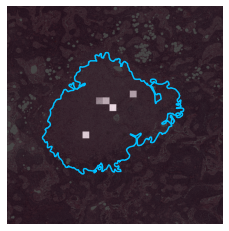

In [176]:
if vis_model == 'attn':
    _A = A_b
    __cam = cam_b
    f_name = 'ABMIL_'
elif vis_model == 'mask':
    _A = A_m
    __cam = cam_m
    f_name = 'MASK_'
elif vis_model == 'tea':
    _A = A_tea
    f_name = 'TEA_'
elif vis_model == 'mhim':
    _A = A_mask
    f_name = 'TEA_'
if roi_coord is None:
    if roi >= 0:
        if json_data is not None:
            pos_anchors = np.array(json_data['positive'][roi]['vertices'])
            top,down,left,right,_ = get_area(pos_anchors,margin_percentage,width_height=[width,height])
        else:
            top,down,left,right,_ = get_area(None,margin_percentage,coords[_a_idx[1]],width_height=[width,height])
    else:
        top,down,left,right = 0,height,0,width
    crop_coords = []
    # print(top,down,left,right)
    for i in range(top, down, stride):
        for j in range(left, right, stride):
            if j + crop_size > width or i + crop_size > height:
                continue
            crop_coords.append((j, i))
    right, down = np.max(crop_coords, 0) + crop_size
else:
    top,down,left,right = roi_coord
print(">>>>>>>>>>>> region coord gotten >>>>>>>>>>>")

scale_level_ratio = np.array(slide.level_dimensions[vis_level]) / np.array(slide.level_dimensions[0])
_w,_h = np.array((right-left, down-top))*scale_level_ratio
# _w,_h = (right-left, down-top)
region = slide.read_region((left, top), list(range(slide.level_count))[vis_level], (int(_w),int(_h))).convert('RGB')
print(">>>>>>>>>>>> slide region gotten >>>>>>>>>>>")
#
A_roi,coords_roi = screen_coords(_A,coords,(left,top),(right,down))
#
img = np.array(region)
# 
coords_roi_rel = []
for i in range(len(coords_roi)):
    rel_x = coords_roi[i][0]-left
    rel_y = coords_roi[i][1] - top
    rel_x,rel_y = np.clip(rel_x,0,right-left),np.clip(rel_y,0,down-top)
    coords_roi_rel.append([rel_x,rel_y])
print(">>>>>>>>>>>> relative coords computed >>>>>>>>>>>")
# 
# 正则化
# roi区域内正则化
if is_norm:
    if rel_norm:
        A_roi = (A_roi - A_roi.min()) / (A_roi.max() - A_roi.min())
    #全局正则化
    else:
        A_roi = (A_roi - _A.min()) / (_A.max() - _A.min())
    # 筛选
A_roi[A_roi<filter_thr] = 0

heatmap = np.zeros(img.shape)
alpha_mat = np.ones(img.shape) *  alpha
# 染色
for _idx,_coord in enumerate(coords_roi_rel):
    heatmap[int(_coord[1]*scale_level_ratio[1]):int((_coord[1]+patch_size)*scale_level_ratio[1]),int(_coord[0]*scale_level_ratio[0]):int((_coord[0]+patch_size)*scale_level_ratio[0]),:] = A_roi[_idx] * 255

#  attn 透明度更改
# for _idx,_coord in enumerate(coords_roi_rel):
#     if A_roi[_idx] != 0:
#         alpha_mat[int(_coord[1]*scale_level_ratio[1]):int((_coord[1]+patch_size)*scale_level_ratio[1]),int(_coord[0]*scale_level_ratio[0]):int((_coord[0]+patch_size)*scale_level_ratio[0]),:] = A_roi[_idx]
#     else:
#         alpha_mat[int(_coord[1]*scale_level_ratio[1]):int((_coord[1]+patch_size)*scale_level_ratio[1]),int(_coord[0]*scale_level_ratio[0]):int((_coord[0]+patch_size)*scale_level_ratio[0]),:] = alpha


print(">>>>>>>>>>>> heatmap computed >>>>>>>>>>>")
#
blended_image = (alpha * img + (1-alpha) * heatmap[:, :, :3])
# blended_image = alpha_mat * img + (1-alpha_mat) * heatmap
blended_image = blended_image.astype(np.uint8)

if vis_size is not None:
    plt.imshow(cv2.resize(blended_image,dsize=(vis_size,vis_size)))
    scale_ratio = (vis_size / img.shape[0])*scale_level_ratio
else:
    plt.imshow(blended_image)
    scale_ratio = scale_level_ratio
print(">>>>>>>>>>>> heatmap draw done>>>>>>>>>>>")
plt.xlim(0,(right-left)*scale_ratio[0])
plt.ylim((down-top)*scale_ratio[1],0)
plt.axis("off")

if json_data is not None:
    for anchors in (json_data['positive']):
        _pos_anchors = np.array(anchors['vertices'])
        plt.plot((_pos_anchors[:, 0]-left) * scale_ratio[0] , (_pos_anchors[:,1]-top)* scale_ratio[1], color='deepskyblue')

path = os.path.join("./vis_figure/sup/tumor/",f_id+f_name+str(roi)+'_attn.png')
plt.savefig(path,dpi=450,bbox_inches='tight')

## Original Image

>>>>>>>>>>>> region coord gotten >>>>>>>>>>>


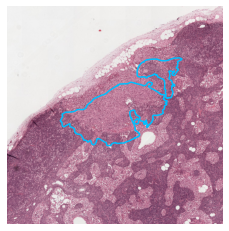

In [60]:
if roi_coord is None:
    if roi >= 0:
        if json_data is not None:
            pos_anchors = np.array(json_data['positive'][roi]['vertices'])
            top,down,left,right,_ = get_area(pos_anchors,margin_percentage,width_height=[width,height])
        else:
            top,down,left,right,_ = get_area(None,margin_percentage,coords[_a_idx[1]],width_height=[width,height])
    else:
        top,down,left,right = 0,height,0,width
    crop_coords = []
    # print(top,down,left,right)
    for i in range(top, down, stride):
        for j in range(left, right, stride):
            if j + crop_size > width or i + crop_size > height:
                continue
            crop_coords.append((j, i))
    right, down = np.max(crop_coords, 0) + crop_size
else:
    top,down,left,right = roi_coord
print(">>>>>>>>>>>> region coord gotten >>>>>>>>>>>")

scale_level_ratio = np.array(slide.level_dimensions[vis_level]) / np.array(slide.level_dimensions[0])
_w,_h = np.array((right-left, down-top))*scale_level_ratio
# _w,_h = (right-left, down-top)
region = slide.read_region((left, top), list(range(slide.level_count))[vis_level], (int(_w),int(_h))).convert('RGB')


plt.imshow(np.array(region))
plt.axis("off")
plt.xlim(0,(right-left)*scale_ratio[0])
plt.ylim((down-top)*scale_ratio[1],0)
if json_data is not None:
    for anchors in (json_data['positive']):
        _pos_anchors = np.array(anchors['vertices'])
        plt.plot((_pos_anchors[:, 0]-left) * scale_ratio[0] , (_pos_anchors[:,1]-top)* scale_ratio[1], color='deepskyblue')
path = os.path.join("./vis_figure/sup/",f_id+f_name+'_'+str(roi)+'_ori'+'.png')
plt.savefig(path,dpi=450,bbox_inches='tight')

## Heatmap

In [19]:
filter_thr = 0.   # attention的阈值，一般0.5比较好
filter_thr_cam = 0.

>>>>>>>>>>>> region coord gotten >>>>>>>>>>>
>>>>>>>>>>>> slide region gotten >>>>>>>>>>>
>>>>>>>>>>cam_roi>>>>>>>>>>>>
tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000])
>>>>>>>>>>>> relative coords computed >>>>>>>>>>>
>>>>>>>>>>>> heatmap computed >>>>>>>>>>>
>>>>>>>>>>>> heatmap draw done>>>>>>>>>>>


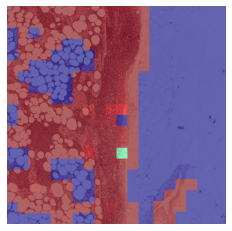

In [20]:
# plt.figure(figsize=(6,6),dpi=300)

if vis_model == 'attn':
    _A = A_b
    __cam = cam_b
    f_name = 'ABMIL_'
elif vis_model == 'mask':
    _A = A_m
    __cam = cam_m
    f_name = 'MASK_'

if roi_coord is None:
    if roi >= 0:
        if json_data is not None:
            pos_anchors = np.array(json_data['positive'][roi]['vertices'])
            top,down,left,right,_ = get_area(pos_anchors,margin_percentage,width_height=[width,height])
        else:
            # normal slide 我找的区域是ab-mil attention最高的那个图块的4周，_a_idx[0]就是这个。可以更换其他点，比如换一下0，或者换成cam排序最高的，_cam_idx
            top,down,left,right,_ = get_area(None,margin_percentage,coords[_a_idx[0]],width_height=[width,height])
    else:
        top,down,left,right = 0,height,0,width
    crop_coords = []
    # print(top,down,left,right)
    for i in range(top, down, stride):
        for j in range(left, right, stride):
            if j + crop_size > width or i + crop_size > height:
                continue
            crop_coords.append((j, i))
    right, down = np.max(crop_coords, 0) + crop_size
else:
    top,down,left,right = roi_coord
print(">>>>>>>>>>>> region coord gotten >>>>>>>>>>>")

scale_level_ratio = np.array(slide.level_dimensions[vis_level]) / np.array(slide.level_dimensions[0])
_w,_h = np.array((right-left, down-top))*scale_level_ratio
# _w,_h = (right-left, down-top)
region = slide.read_region((left, top), list(range(slide.level_count))[vis_level], (int(_w),int(_h))).convert('RGB')
print(">>>>>>>>>>>> slide region gotten >>>>>>>>>>>")
#
A_roi,coords_roi,cam_roi = screen_coords(_A,coords,(left,top),(right,down),cam=__cam)
print(">>>>>>>>>>cam_roi>>>>>>>>>>>>")
sorted_indices = np.argsort(cam_roi)
print(cam_roi[sorted_indices[-5:]])
#
img = np.array(region)
# 
coords_roi_rel = []
for i in range(len(coords_roi)):
    rel_x = coords_roi[i][0]-left
    rel_y = coords_roi[i][1] - top
    rel_x,rel_y = np.clip(rel_x,0,right-left),np.clip(rel_y,0,down-top)
    coords_roi_rel.append([rel_x,rel_y])
print(">>>>>>>>>>>> relative coords computed >>>>>>>>>>>")
# 
# 正则化
# roi区域内正则化
if is_norm:
    if rel_norm:
        A_roi = (A_roi - A_roi.min()) / (A_roi.max() - A_roi.min())
    #全局正则化
    else:
        A_roi = (A_roi - _A.min()) / (_A.max() - _A.min())
    # 筛选
A_roi[A_roi<filter_thr] = 0
cam_roi = (cam_roi - __cam.min()) / (__cam.max() - __cam.min())
cam_roi[cam_roi <= filter_thr_cam] = 0

heatmap_attn = np.zeros(img.shape)[:,:,0]
heatmap_cam = np.zeros(img.shape)
alpha_mat_attn = np.ones(img.shape) * 0.5 * alpha
alpha_mat_cam = np.ones(img.shape) * 0.5 * alpha

for _idx,_coord in enumerate(coords_roi_rel):
    heatmap_attn[int(_coord[1]*scale_level_ratio[1]):int((_coord[1]+patch_size)*scale_level_ratio[1]),int(_coord[0]*scale_level_ratio[0]):int((_coord[0]+patch_size)*scale_level_ratio[0])] = cam_roi[_idx] 

# 创建自定义的colormap
cmap = plt.cm.jet
# 将ListedColormap转换为RGB数组
m = cm.ScalarMappable(norm=None, cmap=cmap)
heatmap = m.to_rgba(heatmap_attn)[:,:,:3] * 255

print(">>>>>>>>>>>> heatmap computed >>>>>>>>>>>")
#
blended_image = (alpha * img + (1-alpha) * heatmap)
# blended_image = (alpha_mat_attn * img + alpha_mat_cam*img + (1-alpha_mat_attn) * heatmap_attn + (1-alpha_mat_cam) * heatmap_cam)
blended_image = blended_image.astype(np.uint8)

# _patch_size = np.ceil(np.array([patch_size,patch_size])).astype(int)
# _patch_size = tuple((_patch_size * (0.01)).astype(int) * 2 +1)
# blended_image = cv2.GaussianBlur(blended_image,_patch_size,0)  

if vis_size is not None:
    plt.imshow(cv2.resize(blended_image,dsize=(vis_size,vis_size)))
    scale_ratio = (vis_size / img.shape[0])*scale_level_ratio
else:
    plt.imshow(blended_image)
    scale_ratio = scale_level_ratio
print(">>>>>>>>>>>> heatmap draw done>>>>>>>>>>>")
plt.xlim(0,(right-left)*scale_ratio[0])
plt.ylim((down-top)*scale_ratio[1],0)
plt.axis("off")

if json_data is not None:
    for anchors in (json_data['positive']):
        _pos_anchors = np.array(anchors['vertices'])
        plt.plot((_pos_anchors[:, 0]-left) * scale_ratio[0] , (_pos_anchors[:,1]-top)* scale_ratio[1], color=(0,128/255,1),linewidth=3.0)

if save_figure:
    path = os.path.join("./vis_figure/dpi450/",f_id+f_name+'.png')
    plt.savefig(path,dpi=450,bbox_inches='tight')

In [13]:
_patch_size

512

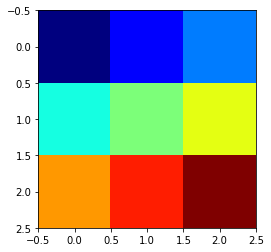

In [44]:
# 创建一个概率值数组
prob = np.array([0.1, 0.2, 0.3, 0.4, 0.5,0.6,0.7,0.8,0.9])

# 创建一个colormap对象
cmap = plt.cm.jet

# 使用cm.ScalarMappable方法将概率值转换为cmap rgb array
m = cm.ScalarMappable(norm=None, cmap=cmap)
rgb = m.to_rgba(prob.reshape(3,3))[:,:,:3] * 255

# 打印cmap rgb array
plt.imshow(rgb.astype(np.uint8))